In [1]:
import numpy as np
import pandas as pd
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from scipy import optimize
import sys
sys.path.append('../SEIR_full/')
sys.path.append('..')
import SEIR_full as mdl
import SEIR_full.model_class as mdl
from PolicyOptimization import EvaluatePolicy as pol
import datetime as dt
from scipy.stats import poisson
from scipy.stats import binom
import copy
import os
import time
from operator import add

In [2]:
with (open('../Data/parameters/indices.pickle', 'rb')) as openfile:
    ind = pickle.load(openfile)

# reconstructing sergey old opt

In [3]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
#     (1,'-'),
    (1, 29),
#     (2, 29),
#     (3, 29),
]

stops_type = [
#     (True, 'all'),
#     (True, 'risk'),
#     (True, 'kid'),
#     (True, 'nothing'),
#     (False, 'all'),
#     (False, 'risk'),
    (False, 'kid'),
]

In [4]:
policy_params_list = []
policy_params = {
    'policy_period': 7,
    'stop_inter': mdl.inter2name(ind, 10),
    'free_inter': mdl.inter2name(ind, 100, no_risk=False),
    'deg_param': None,
    'global_thresh': False,
    'max_duration': 100,
    'threshold': 0.5,
}
# policy_params = {
#     'policy_period': 7,
#     'stop_inter': mdl.inter2name(ind, 10),
#     'free_inter': mdl.inter2name(ind, 100, no_risk=False),
#     'deg_param': None,
#     'global_lock': True,
#     'global_thresh': True,
#     'max_duration': 2,
#     'threshold': 5e2,
# }

# [Is, new_Is, H, Vent]
policy_params['weight_matrix'] = np.zeros([4,9])
policy_params['weight_matrix'][1][:] = 1
policy_params_list.append(policy_params.copy())

# policy_params['threshold']=0.2
# policy_params_list.append(policy_params.copy())

# policy_params['threshold']=0.4
# policy_params_list.append(policy_params.copy())

# policy_params['threshold']=0.6
# policy_params_list.append(policy_params.copy())

# policy_params['threshold']=0.8
# policy_params_list.append(policy_params.copy())

# policy_params['threshold']=5
# policy_params_list.append(policy_params.copy())

# policy_params['threshold']=7
# policy_params_list.append(policy_params.copy())

# policy_params['threshold'] = 1000
# policy_params_list.append(policy_params.copy())

In [5]:
len(policy_params_list)

1

In [6]:
start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}
res_mdl = {}
pol_states = {}
for scen_idx, phase in cal_parameters.keys():
    if phase == '-':
        seasonality = False
        phi=0
    else:
        seasonality = True
        phi=phase
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[(scen_idx, phase)]['beta_j'],
        theta=cal_parameters[(scen_idx, phase)]['theta'],
        beta_behave=cal_parameters[(scen_idx, phase)]['beta_behave'],
        mu=cal_parameters[(scen_idx, phase)]['mu'],
        nu=cal_parameters[(scen_idx, phase)]['nu'],
        eta=cal_parameters[(scen_idx, phase)]['eta'],
        xi=cal_parameters[(scen_idx, phase)]['xi'],
        scen=mdl.num2scen(scen_idx),
        seasonality=seasonality,
        phi=phi,
    )

    res = model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    for glob, stop in stops_type:
        res_mdl[(scen_idx, phase, stop)] = []
        pol_states[(scen_idx, phase, stop)] = []
        for policy_params in policy_params_list:
            
            policy_params['global_thresh'] = glob
            policy_params['global_lock'] = glob
            if stop == 'all':
                policy_params['stop_inter'] = mdl.inter2name(ind, 10)
            elif stop == 'kid':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=False, no_kid=True)
            elif stop == 'risk':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=True)
                policy_params['free_inter'] = mdl.inter2name(ind, 100, no_risk=False)
            elif stop == 'nothing':
                policy_params['stop_inter'] = mdl.inter2name(ind, 100, no_risk=False)
                policy_params['free_inter'] = mdl.inter2name(ind, 100, no_risk=False)
            
            thresh = policy_params['threshold']
            print('Doing: ', ' '.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]))
            res_mdl_glob_i, pol_states_i = pol.run_global_policy(
                ind, 
                model, 
                policy_params, 
                3*365+1, 
                mdl.pop_israel,
                start=(start_inter-beginning).days,
            )
            with open('../Data/results/quarantine_mod_res' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle', 'wb') as handle:
                    pickle.dump(res_mdl_glob_i, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open('../Data/results/quarantine_regions' + 
                      '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                       '.pickle', 'wb') as handle:
                pickle.dump(pol_states_i, handle, protocol=pickle.HIGHEST_PROTOCOL)
#             res_mdl[(scen_idx, phase, stop, glob, thresh)] = res_mdl_glob_i.copy()
#             pol_states[(scen_idx, phase, stop, glob, thresh)] = pol_states_i.copy()

Doing:  1 29 all False 0.5
Doing:  1 29 risk False 0.5
Doing:  2 29 all False 0.5
Doing:  2 29 risk False 0.5
Doing:  3 29 all False 0.5
Doing:  3 29 risk False 0.5


(1, '-', 'risk')
After  3.0  years:
(1, '-', 'risk', True, 1)
Recovered cases max:  68.67001550984442
total casulties:  11417.375754603614
total casulties saved per quar:  8333.250793648742
(1, '-', 'risk', True, 2)
Recovered cases max:  74.42465067546048
total casulties:  16879.778922258232
total casulties saved per quar:  2870.8476259941235
(1, '-', 'risk', True, 3)
Recovered cases max:  76.95371517497172
total casulties:  19750.626548252356
total casulties saved per quar:  0.0
(1, '-', 'risk', True, 4)
Recovered cases max:  76.95371517497172
total casulties:  19750.626548252356
total casulties saved per quar:  0.0
(1, '-', 'risk', True, 5)
Recovered cases max:  76.95371517497172
total casulties:  19750.626548252356
total casulties saved per quar:  0.0
(1, '-', 'risk', True, 6)
Recovered cases max:  76.95371517497172
total casulties:  19750.626548252356
total casulties saved per quar:  0.0
(1, '-', 'risk', True, 7)
Recovered cases max:  76.95371517497172
total casulties:  19750.62654

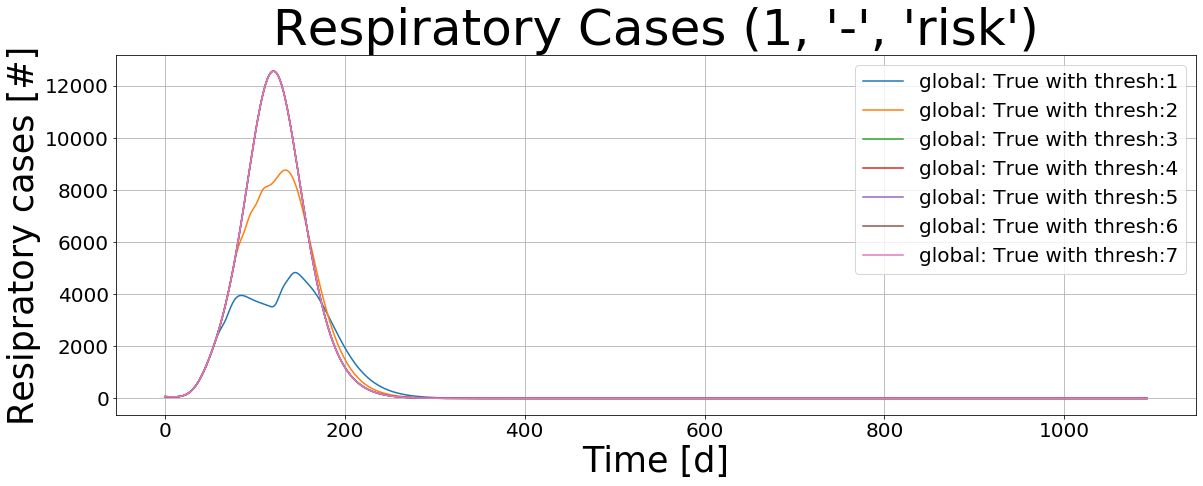

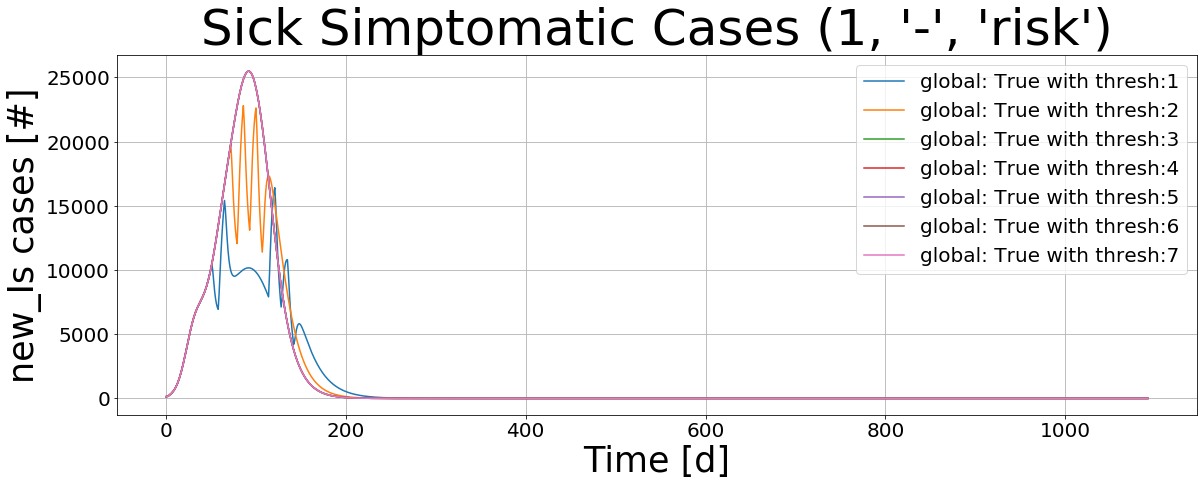

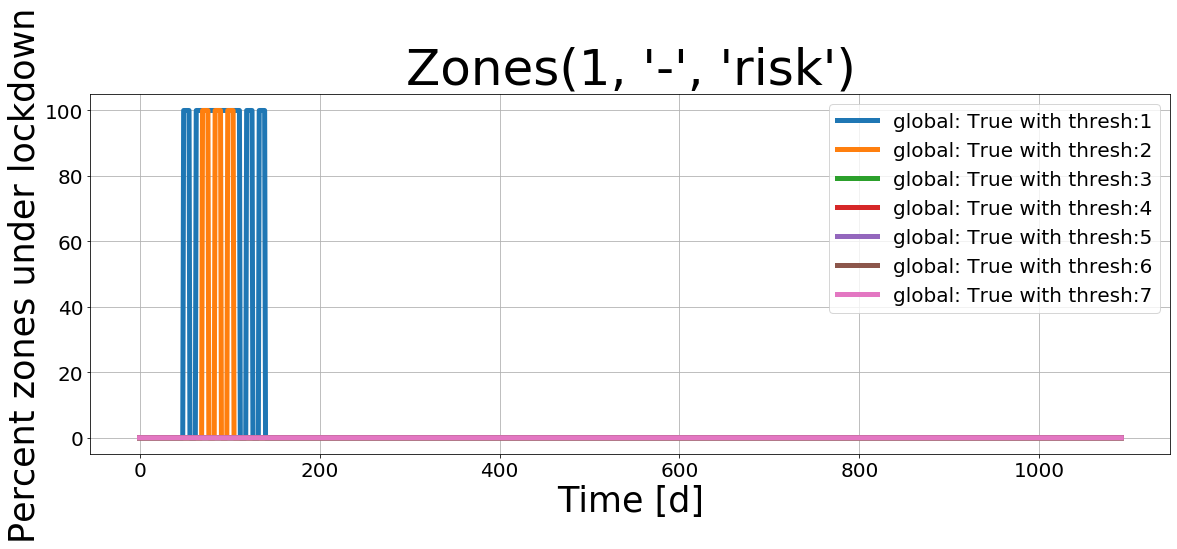

range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)


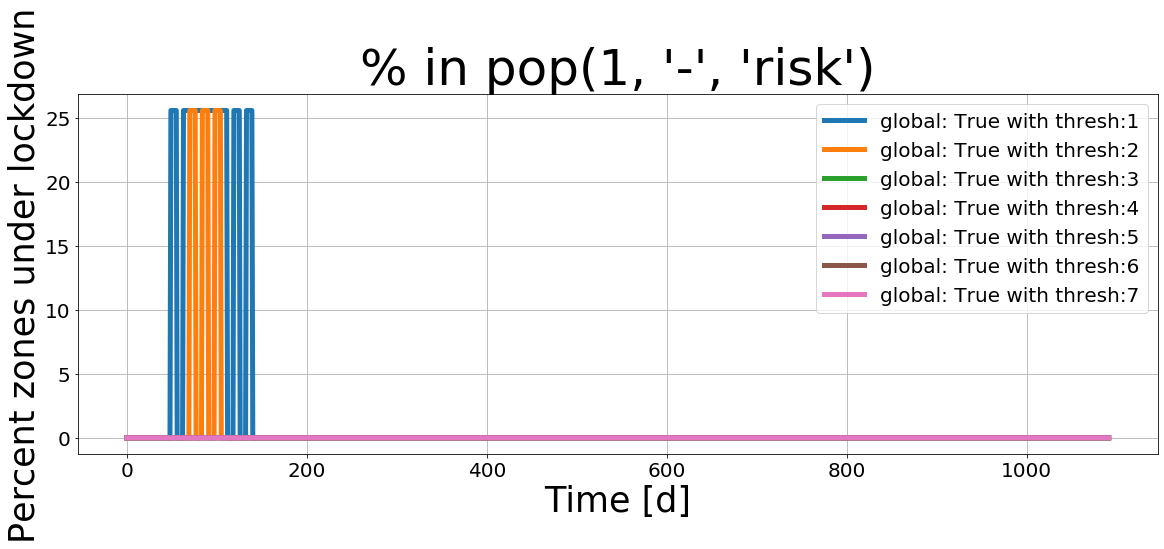

(1, '-', 'risk')
After  3.0  years:
(1, '-', 'risk', False, 1)
Recovered cases max:  67.10844360199297
total casulties:  10092.566800561164
total casulties saved per quar:  9658.059747691192
(1, '-', 'risk', False, 2)
Recovered cases max:  71.89420240149197
total casulties:  14341.810147190285
total casulties saved per quar:  5408.816401062071
(1, '-', 'risk', False, 3)
Recovered cases max:  74.3654050577509
total casulties:  16832.45097229805
total casulties saved per quar:  2918.175575954305
(1, '-', 'risk', False, 4)
Recovered cases max:  76.00589713339677
total casulties:  18661.313197046584
total casulties saved per quar:  1089.313351205772
(1, '-', 'risk', False, 5)
Recovered cases max:  76.77636801244459
total casulties:  19530.111576857307
total casulties saved per quar:  220.51497139504863
(1, '-', 'risk', False, 6)
Recovered cases max:  76.85630293062988
total casulties:  19628.01244729015
total casulties saved per quar:  122.61410096220425
(1, '-', 'risk', False, 7)
Recovere

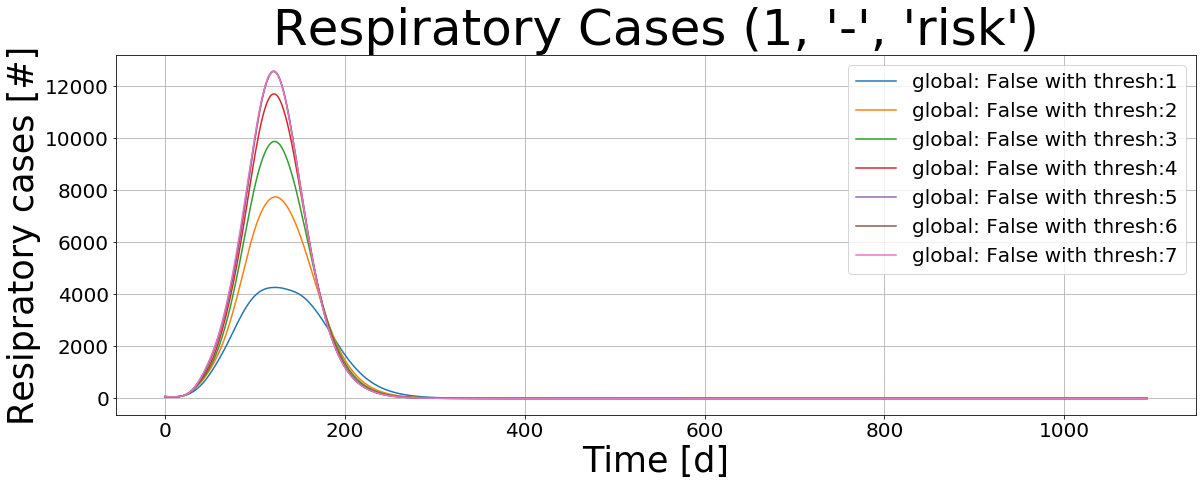

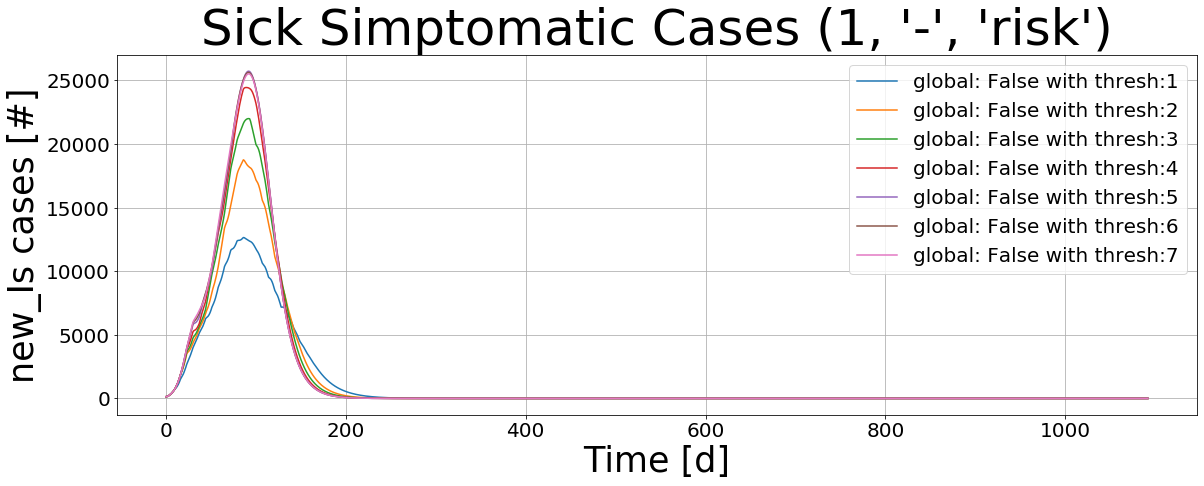

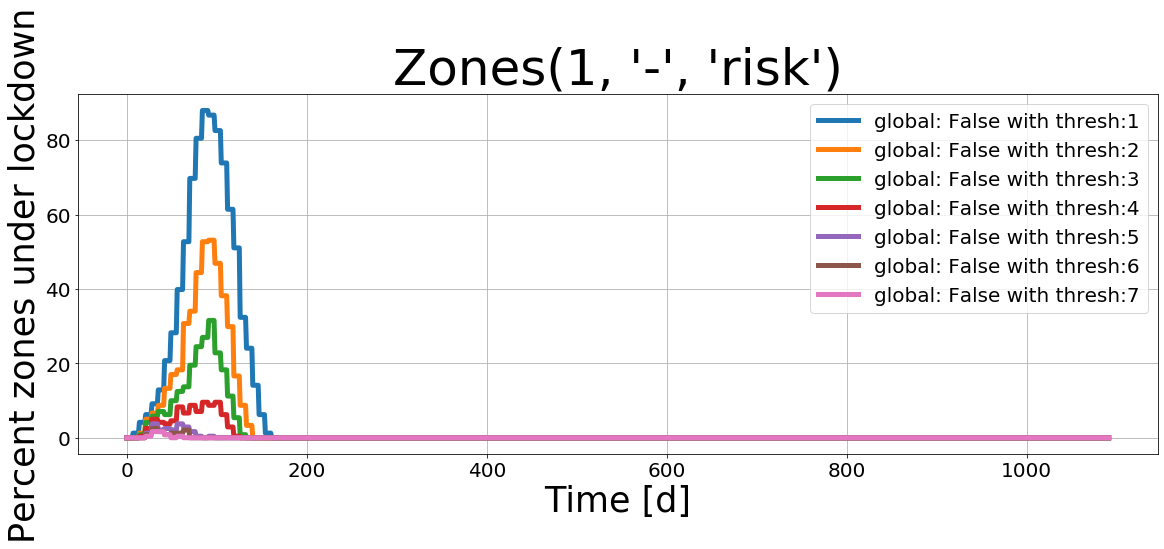

range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)


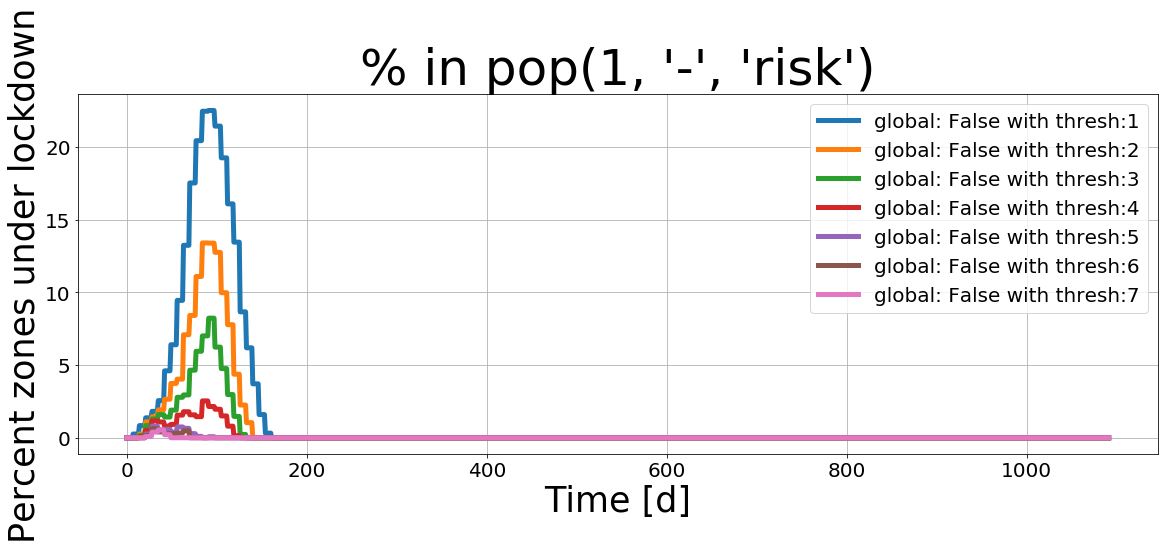

(1, 29, 'risk')
After  3.0  years:
(1, 29, 'risk', True, 1)
Recovered cases max:  74.97224120877404
total casulties:  10329.104266143919
total casulties saved per quar:  12823.285780430664
(1, 29, 'risk', True, 2)
Recovered cases max:  80.81002530107087
total casulties:  16044.003471486756
total casulties saved per quar:  7108.386575087827
(1, 29, 'risk', True, 3)
Recovered cases max:  84.30760691399504
total casulties:  20113.09959738955
total casulties saved per quar:  3039.2904491850313
(1, 29, 'risk', True, 4)
Recovered cases max:  85.415902260871
total casulties:  21573.332265743837
total casulties saved per quar:  1579.0577808307462
(1, 29, 'risk', True, 5)
Recovered cases max:  86.52721346953676
total casulties:  23152.390046574583
total casulties saved per quar:  0.0
(1, 29, 'risk', True, 6)
Recovered cases max:  86.52721346953676
total casulties:  23152.390046574583
total casulties saved per quar:  0.0
(1, 29, 'risk', True, 7)
Recovered cases max:  86.52721346953676
total casu

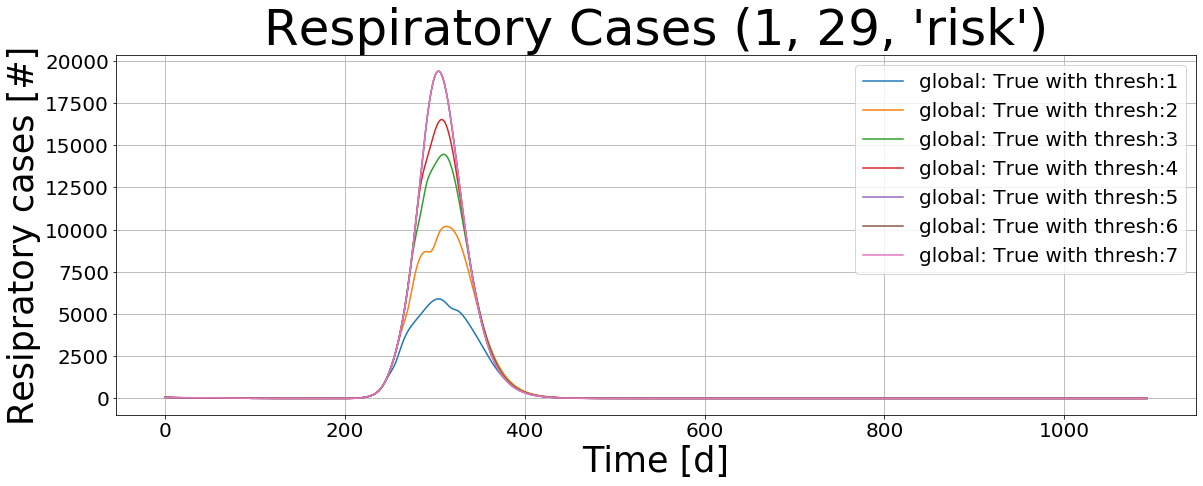

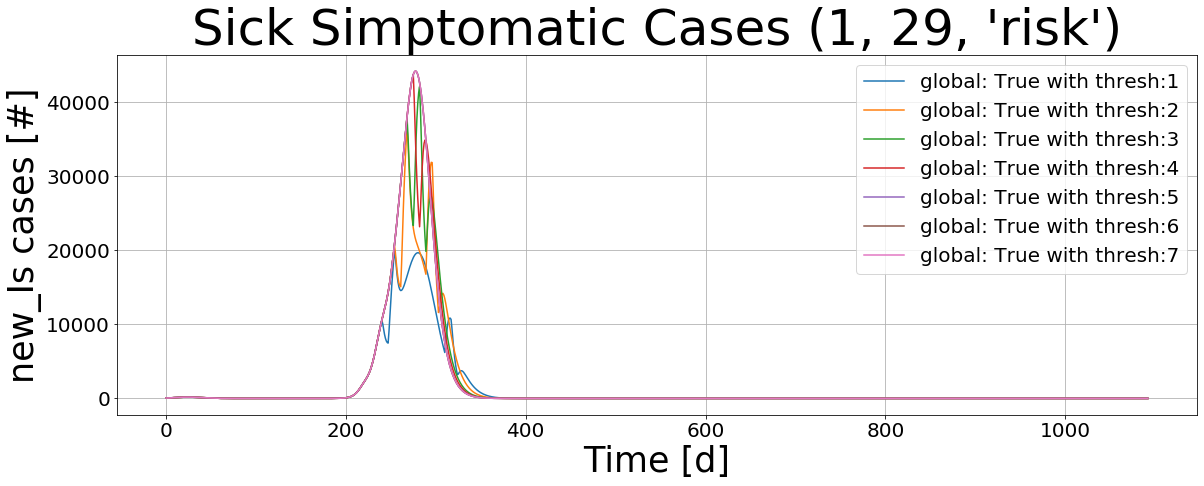

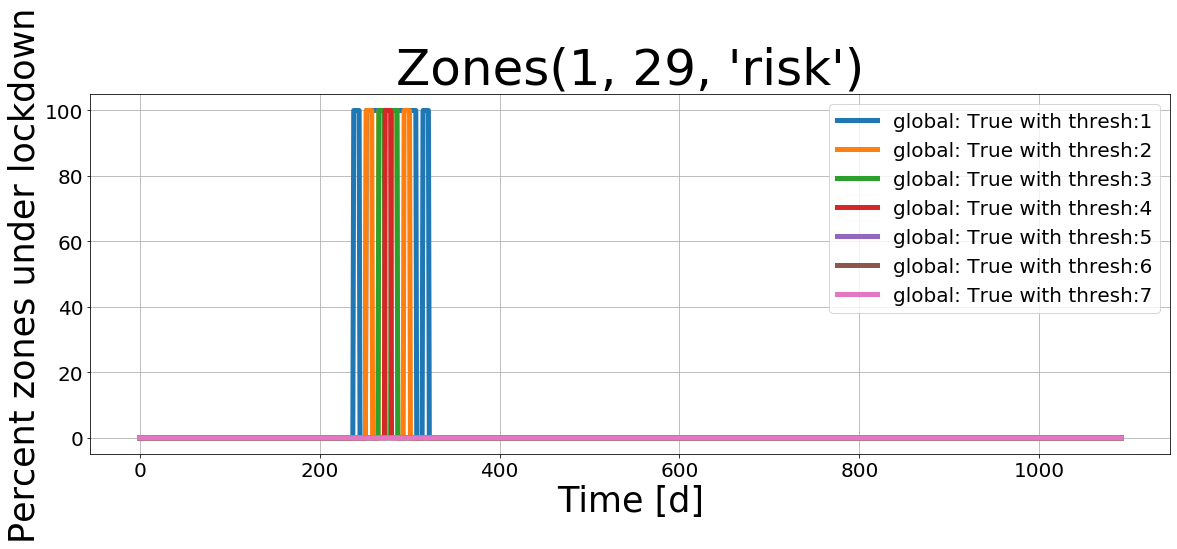

range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)


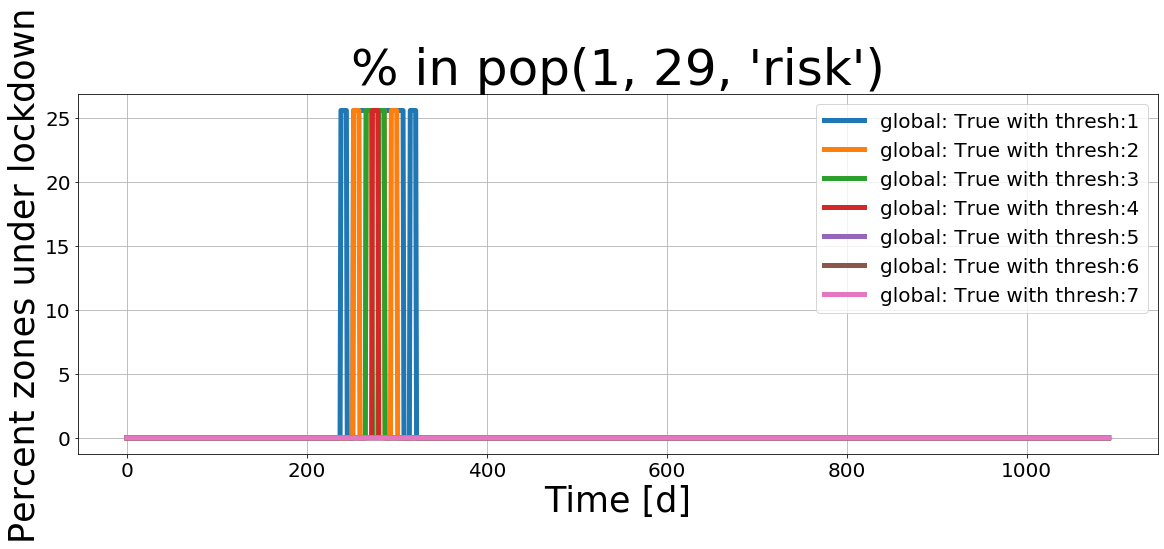

(1, 29, 'risk')
After  3.0  years:
(1, 29, 'risk', False, 1)
Recovered cases max:  74.93712895881369
total casulties:  10140.149880582216
total casulties saved per quar:  13012.240165992367
(1, 29, 'risk', False, 2)
Recovered cases max:  77.7383146764681
total casulties:  12789.678187971556
total casulties saved per quar:  10362.711858603026
(1, 29, 'risk', False, 3)
Recovered cases max:  80.3906879949607
total casulties:  15508.095632706747
total casulties saved per quar:  7644.294413867836
(1, 29, 'risk', False, 4)
Recovered cases max:  82.50468904728065
total casulties:  17877.984379678517
total casulties saved per quar:  5274.405666896066
(1, 29, 'risk', False, 5)
Recovered cases max:  83.94595152070852
total casulties:  19624.554182030097
total casulties saved per quar:  3527.835864544486
(1, 29, 'risk', False, 6)
Recovered cases max:  84.88029528055627
total casulties:  20841.93585864406
total casulties saved per quar:  2310.4541879305216
(1, 29, 'risk', False, 7)
Recovered cases

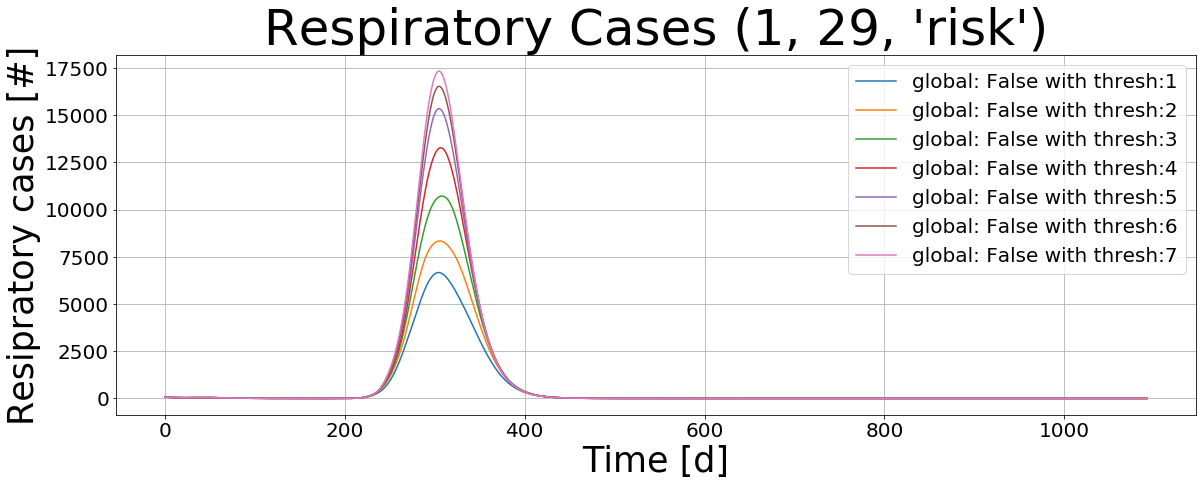

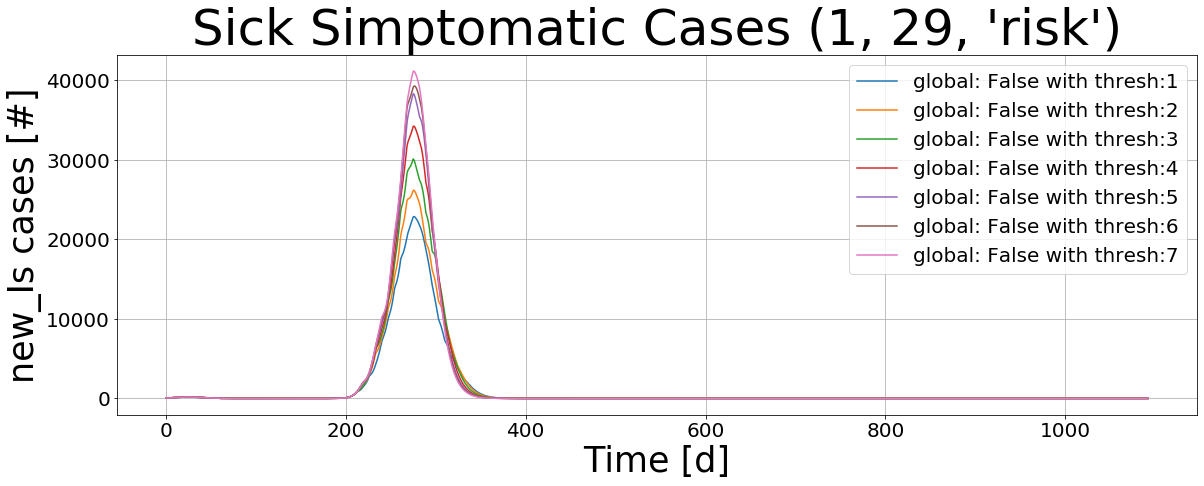

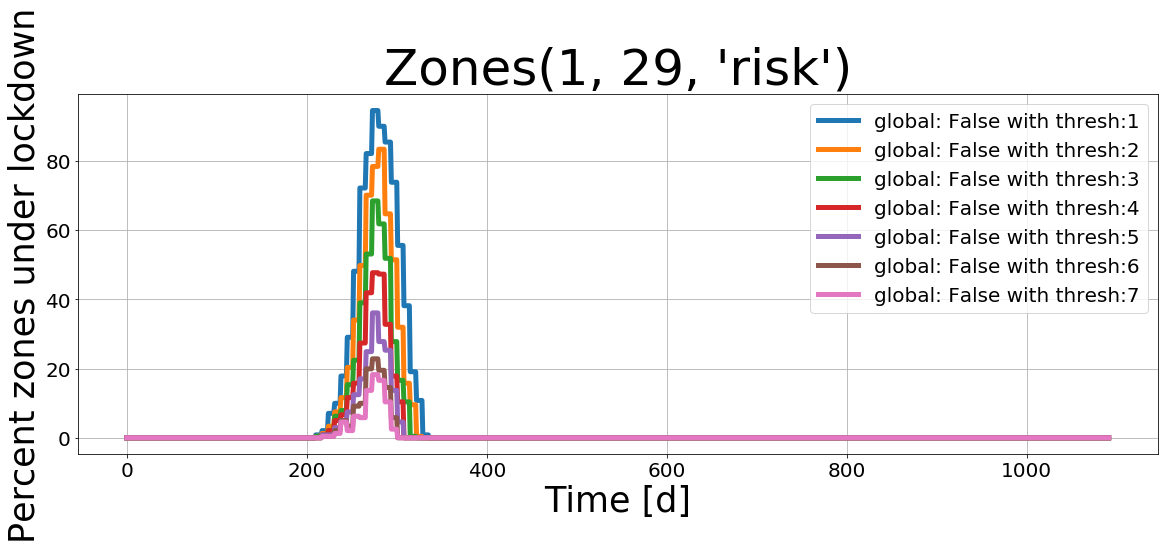

range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)
range(0, 1092)


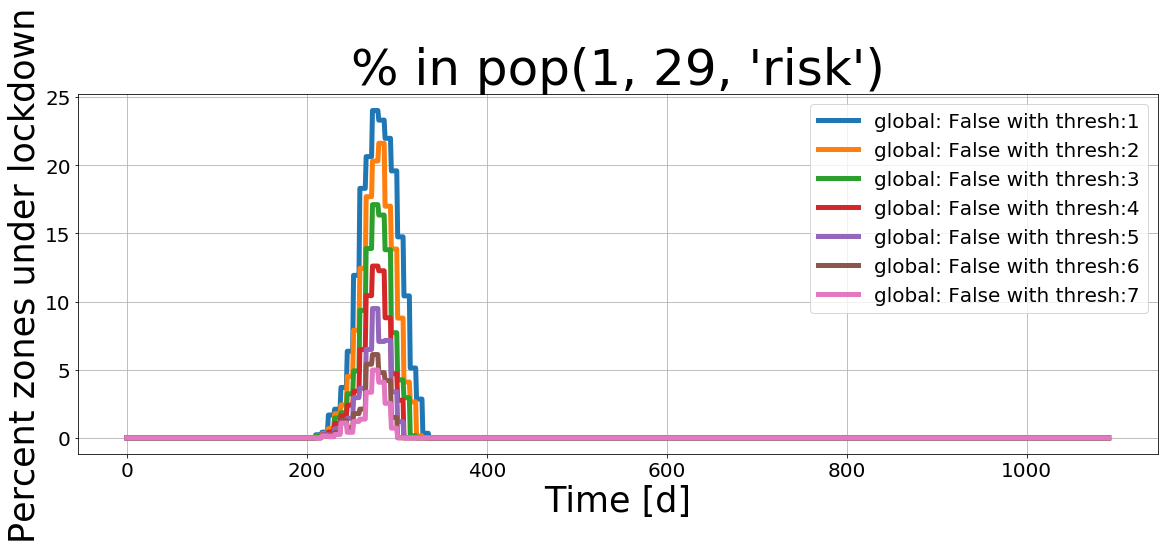

In [31]:
cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    for glob, stop in stops_type:
        print((scen_idx, phase, stop))
        for y in 365*np.array([3]):
            print('After ', y/365.0, ' years:')
            for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#             for thresh in [1]:
                if thresh == 1000:
                    continue
#                 print(policy_params_list[i])
                print((scen_idx, phase, stop, glob, thresh))
                print('Recovered cases max: ',
                      mdl.make_recoveries(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y)))
                print('total casulties: ', 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu))
                print('total casulties saved per quar: ', 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, 1000)], int(y), mdl.pop_israel, model.mu) - 
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu))
            print()
        
        # number of resperatory cases global.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            ax.plot(
                ((res_mdl[(scen_idx, phase, stop, glob, thresh)]['Vents']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
                label=('global: '+ 
                       str(glob) +
                       ' with thresh:' + 
                       str(thresh)))
        ax.set_ylabel('Resipratory cases [#]', fontsize=35)
        ax.set_title('Respiratory Cases ' + str((scen_idx, phase, stop)), fontsize=50)
        ax.set_xlabel('Time [d]', fontsize=35)
        # ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
        ax.legend(fontsize = 20)
        ax.grid('on')
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # number of new cases global.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            ax.plot(
                ((res_mdl[(scen_idx, phase, stop, glob, thresh)]['new_Is']).sum(axis=1))[(start_inter-beginning).days:]*mdl.pop_israel, 
                label=('global: '+ 
                       str(glob) +
                       ' with thresh:' + 
                       str(thresh)))
        ax.set_ylabel('new_Is cases [#]', fontsize=35)
        ax.set_title('Sick Simptomatic Cases ' + str((scen_idx, phase, stop)), fontsize=50)
        ax.set_xlabel('Time [d]', fontsize=35)
        # ax.axvline(x=(start_inter-beginning).days+7, c='k', linewidth=2, linestyle='--')
        ax.legend(fontsize = 20)
        ax.grid('on')
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

        # pct of regions in quaer.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            pol_pct = [100*sum(list(x.values()))/len(x) for x in pol_states[(scen_idx, phase, stop, glob, thresh)]]
            ax.plot(pol_pct,linewidth=5, label=('global: '+ 
                           str(glob) +
                           ' with thresh:' + 
                           str(thresh)))
        ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('Time [d]', fontsize=35)
        ax.set_title('Zones' + str((scen_idx, phase, stop)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
        
        # pct of pop in quaer.
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        if stop == 'all':
            pop_per_region = [np.sum(mdl.population_size[ind.region_dict[region]]) for region in ind.G.values()]
        elif stop == 'kid':
            pop_per_region = [mdl.population_size[list(set(ind.region_age_dict[(region, '0-4')]).union(
                                 set(ind.region_age_dict[(region, '5-9')])).union(
                                 set(ind.region_age_dict[(region, '10-19')])))].sum()
                                 for  region in list(ind.G.values())
                             ]
        elif stop == 'risk':
            pop_per_region = list(map(add, 
                [mdl.population_size[list(set(ind.region_risk_dict[(region, 'High')]).union(
                    set(ind.region_age_dict[(region, '70+')])))].sum()
                    for  region in list(ind.G.values())
                ], 
                [mdl.population_size[list(set(ind.region_risk_dict[(region, 'Low')]).intersection(
                    set(ind.region_age_dict[(region, '60-69')])))].sum()*0.5
                    for region in list(ind.G.values())
                ],
            ))
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
            if thresh == 1000:
                continue
            print(range(len(pol_states[(scen_idx, phase, stop, glob, thresh)])))
            pol_pct = [100*sum(np.multiply(list(x.values()), pop_per_region)) 
                       for x in pol_states[(scen_idx, phase, stop, glob, thresh)]]
            ax.plot(pol_pct,linewidth=5, label=('global: '+ 
                           str(glob) +
                           ' with thresh:' + 
                           str(thresh)))
        ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('Time [d]', fontsize=35)
        ax.set_title('% in pop' + str((scen_idx, phase, stop)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()

After  1.0  year:
(1, '-')


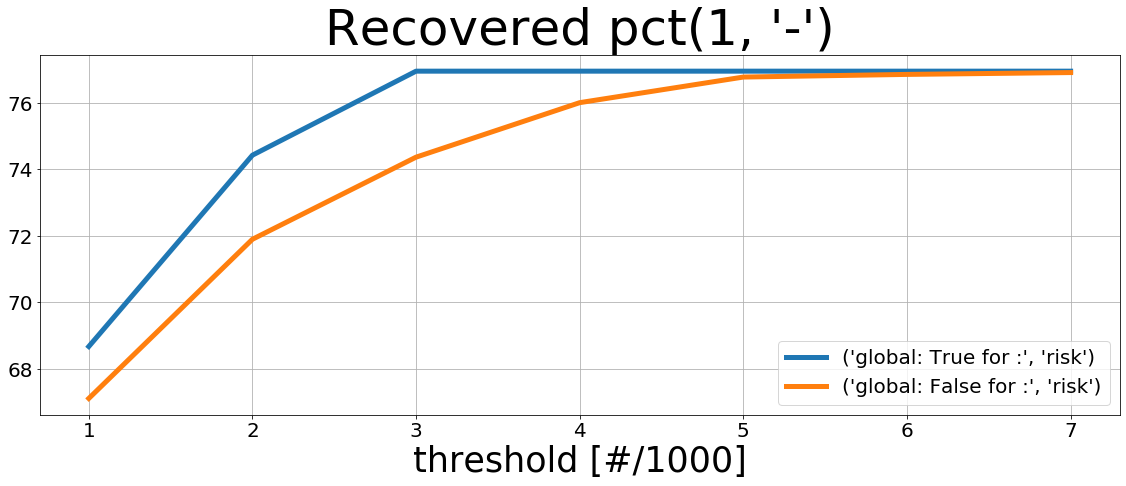

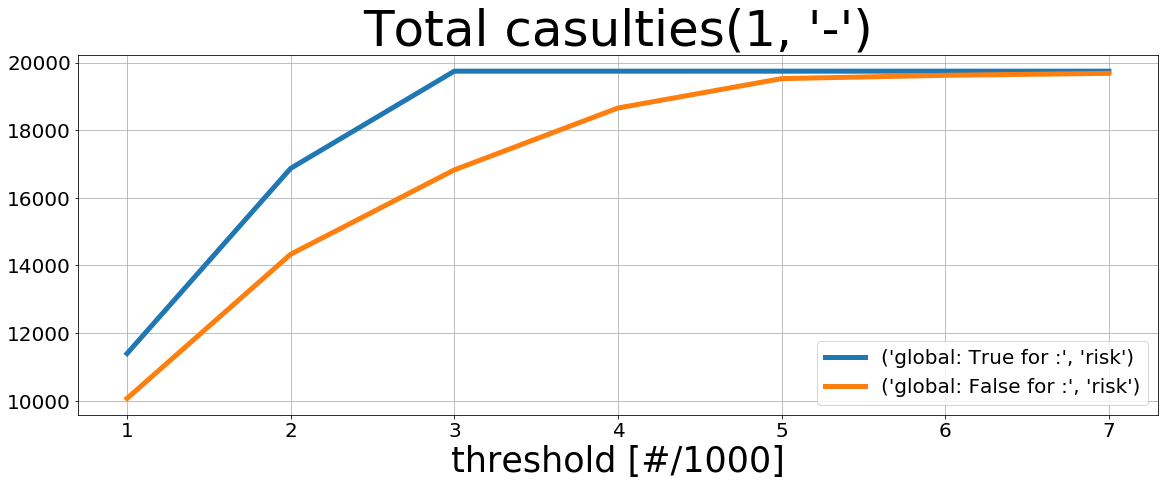

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


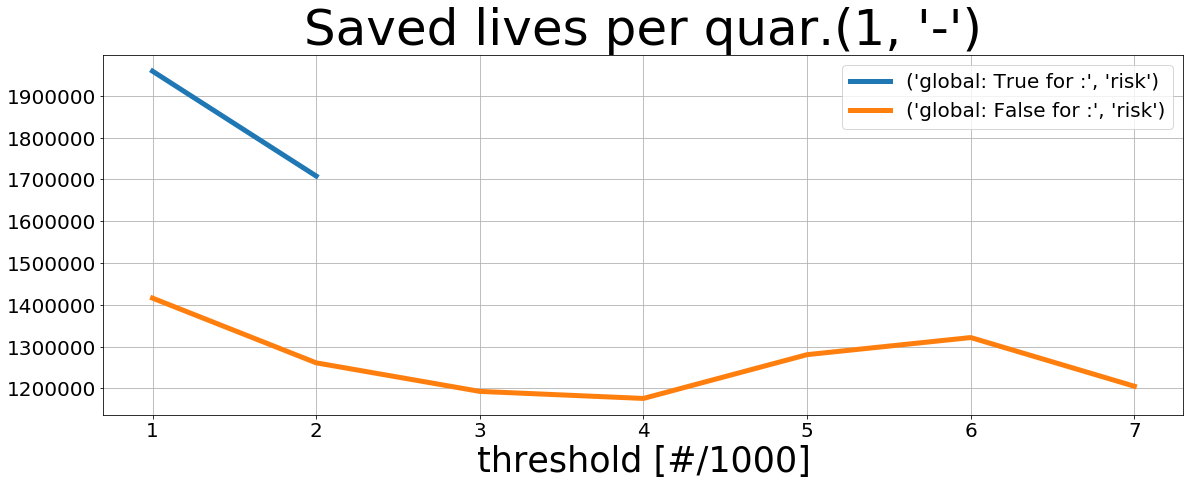

After  2.0  year:
(1, '-')


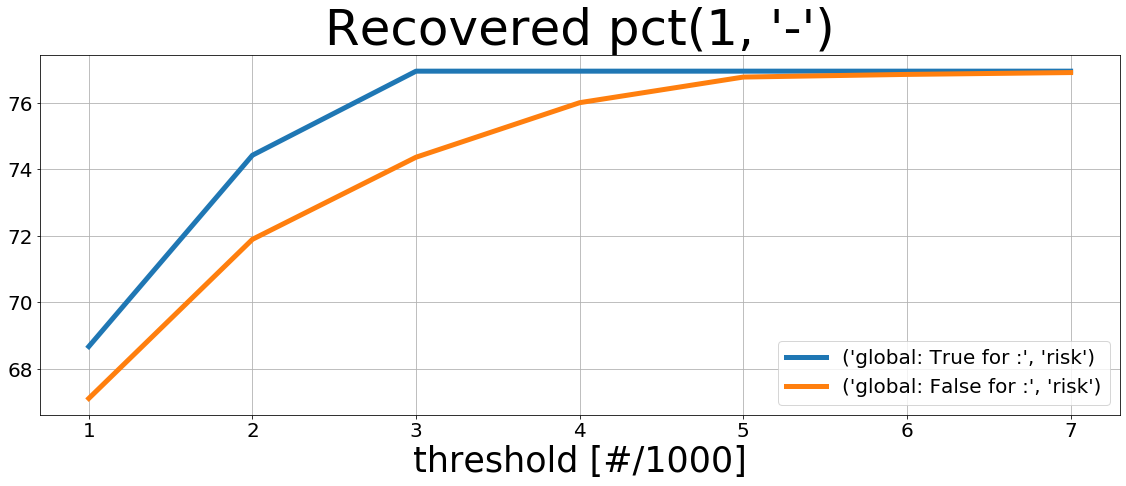

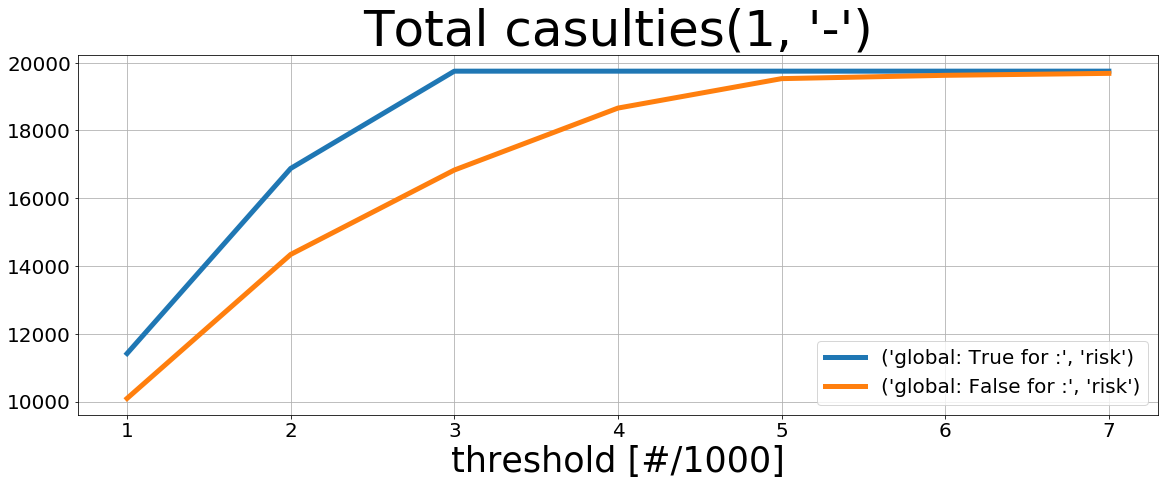

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


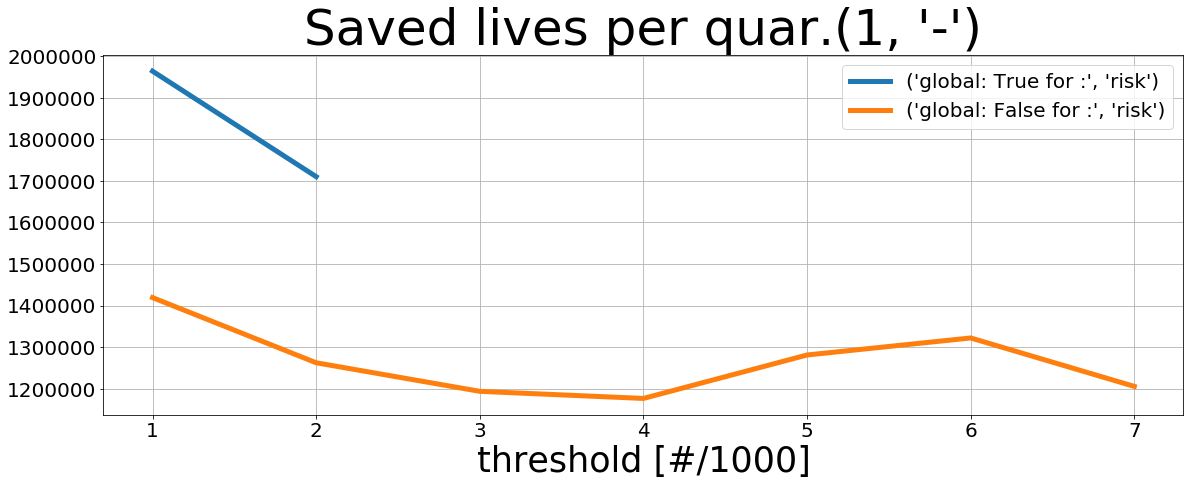

After  3.0  year:
(1, '-')


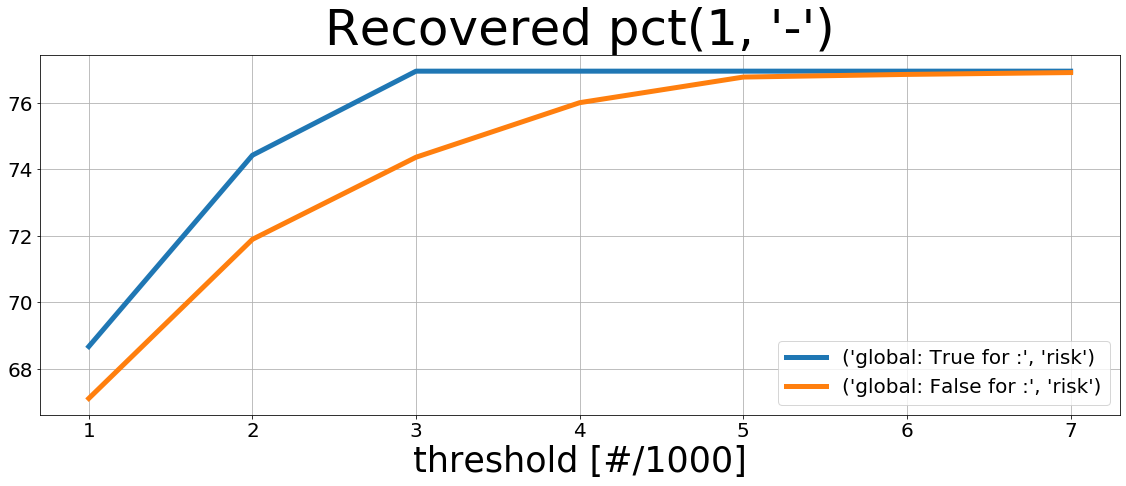

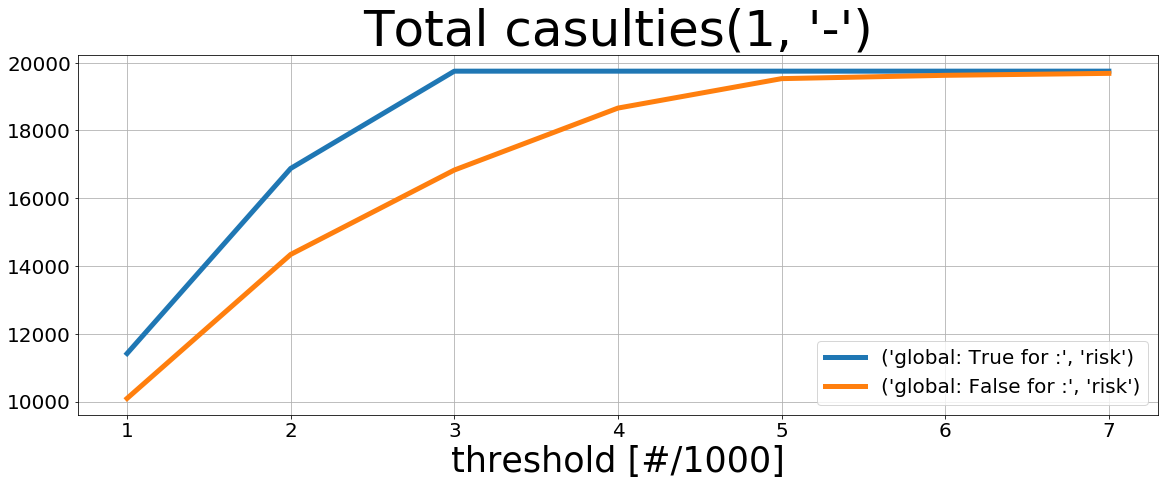

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


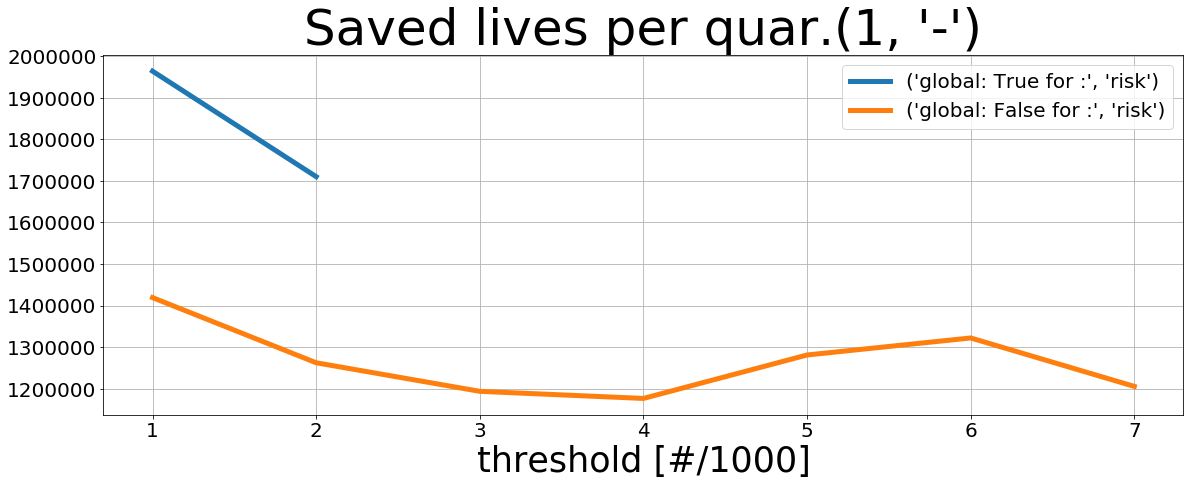

After  1.0  year:
(1, 29)


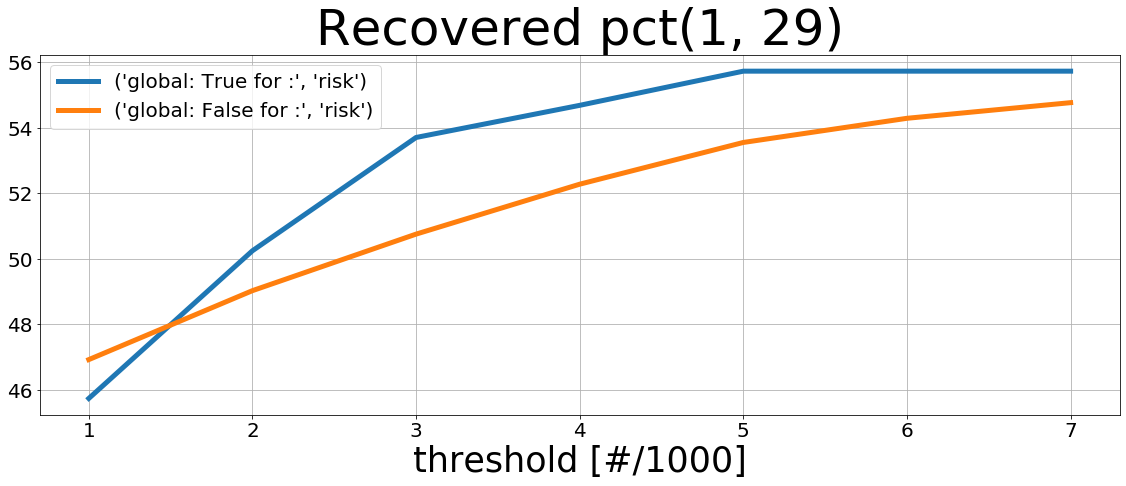

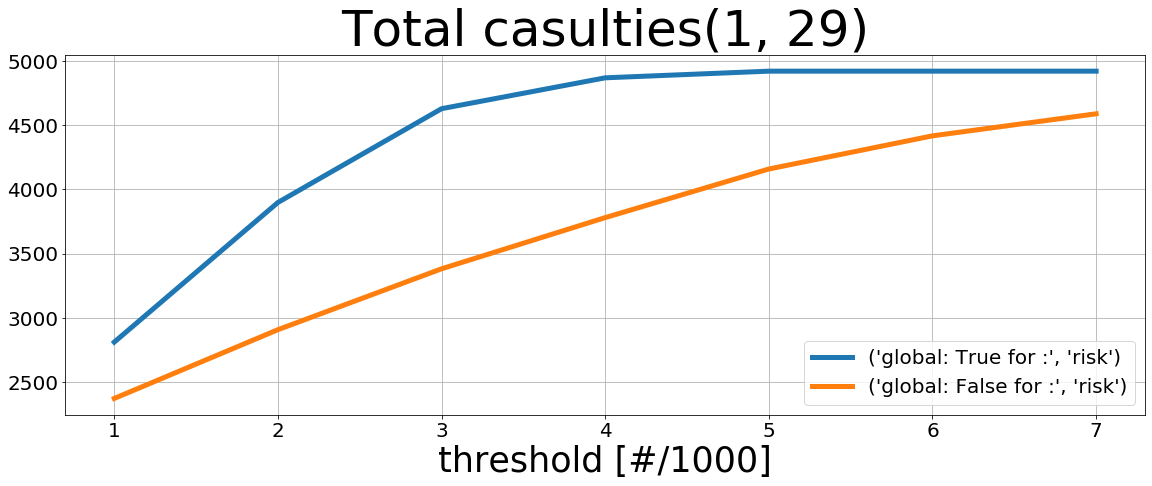

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


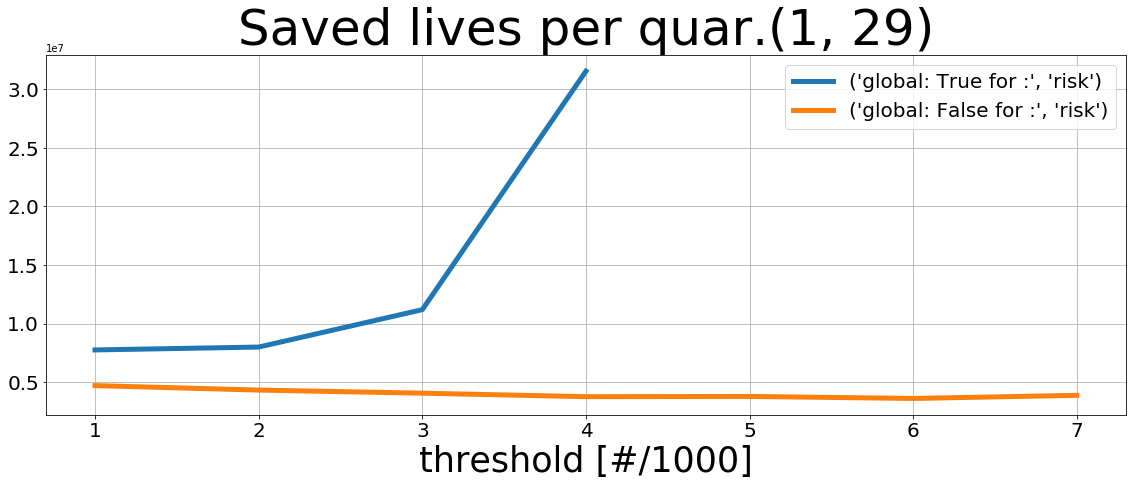

After  2.0  year:
(1, 29)


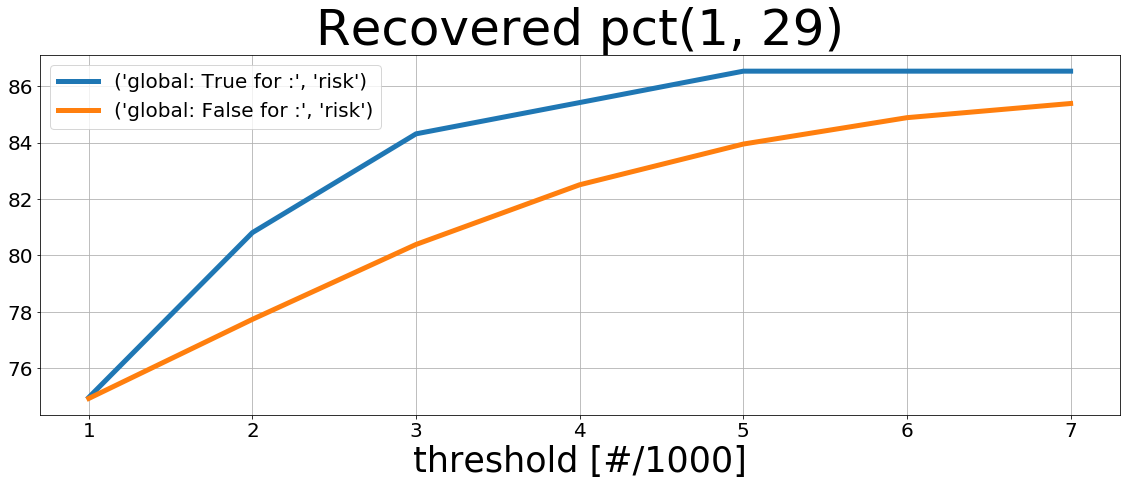

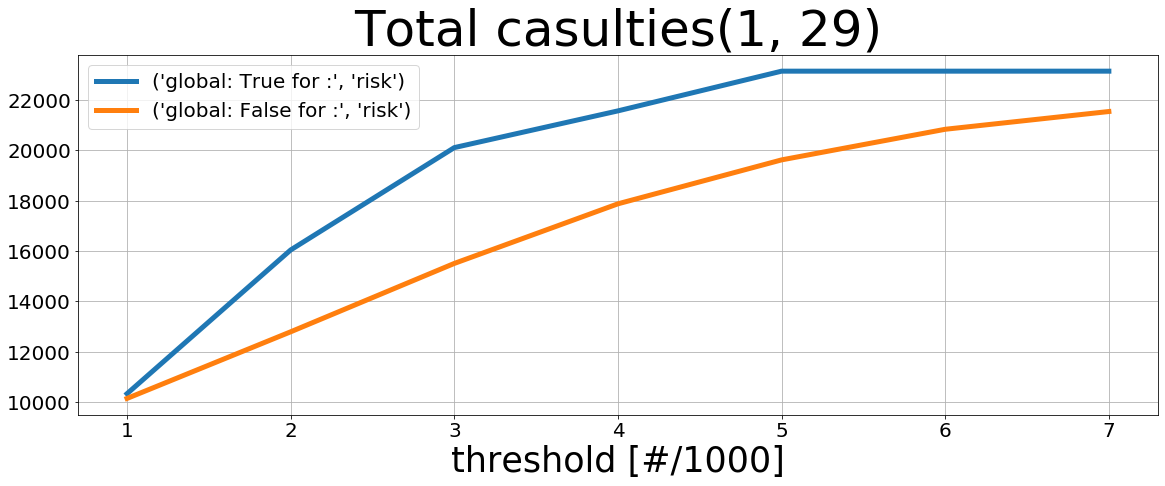

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


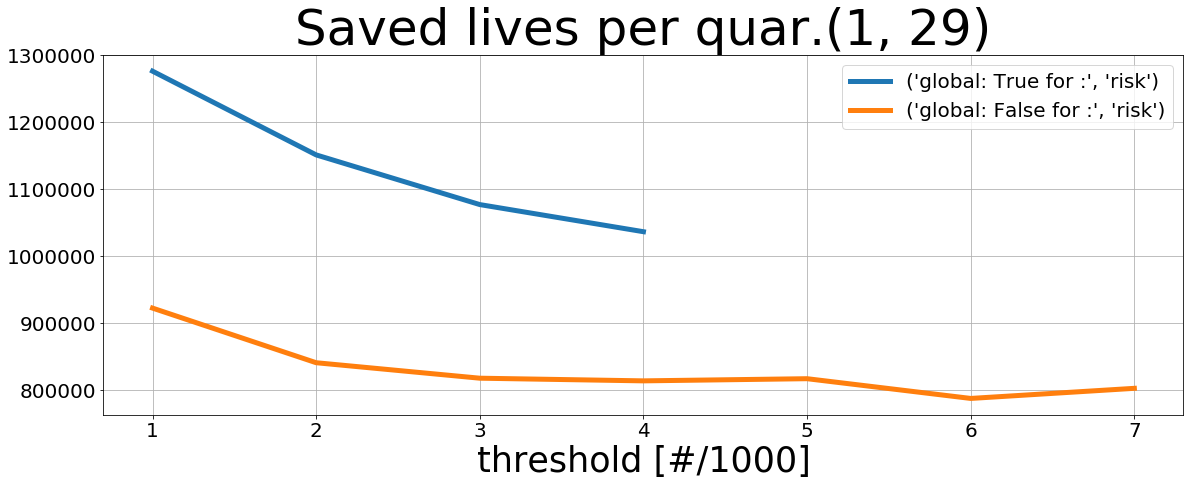

After  3.0  year:
(1, 29)


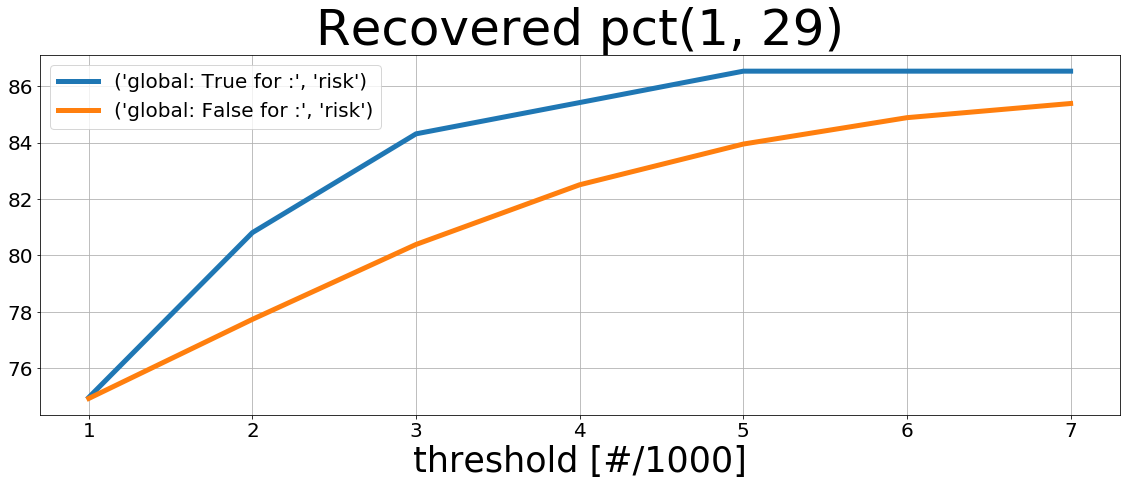

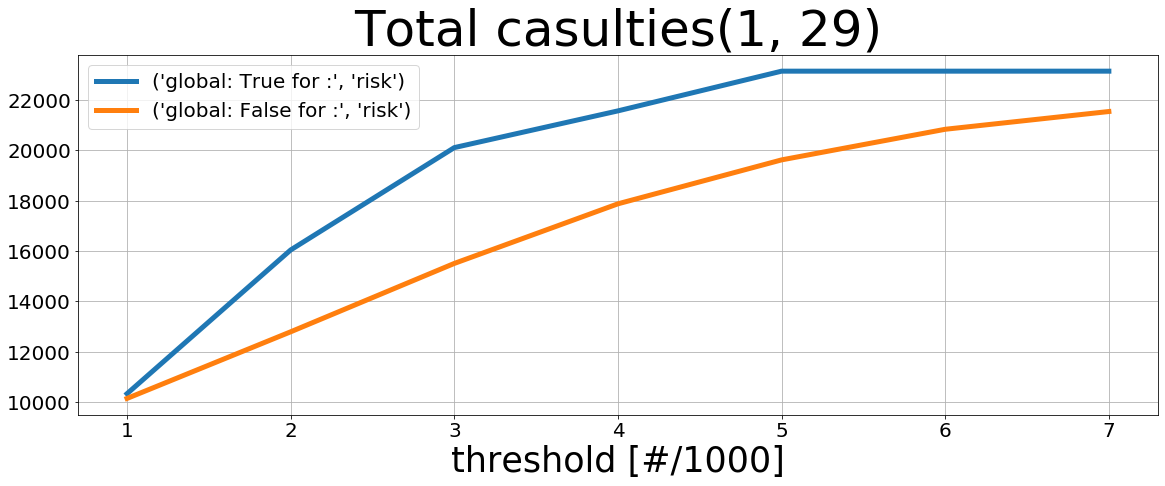

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


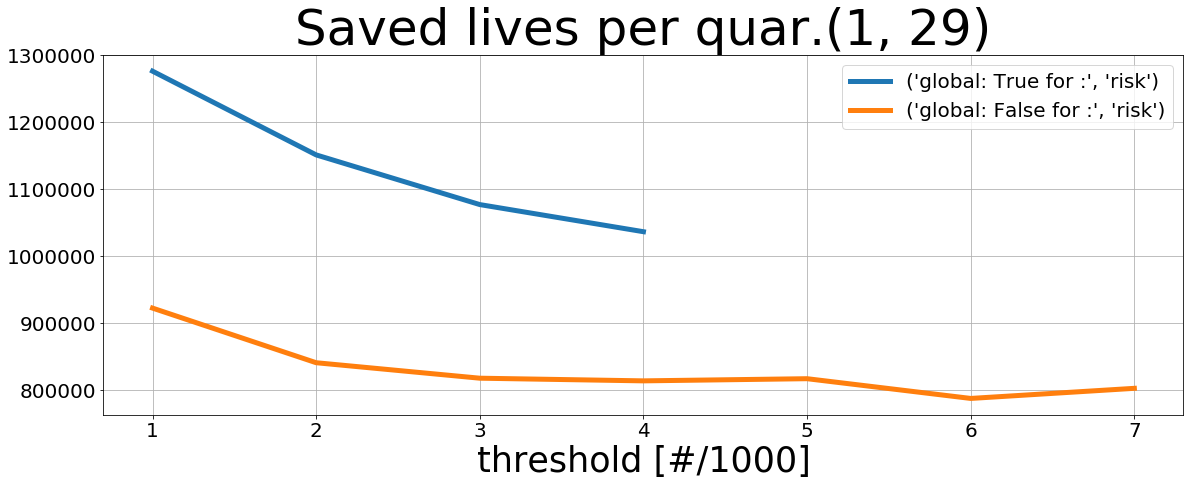

In [40]:
for scen_idx, phase in cal_parameters.keys():
    for y in 365*np.array([1, 2, 3]):
        print('After ', y/365.0, ' year:')
        print((scen_idx, phase))
        # make recoveres:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            recovered = []
            threshs = []
            for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
                if thresh == 1000:
                    continue
                threshs.append(thresh)
                recovered.append(mdl.make_recoveries(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y)))
            ax.plot(threshs, recovered,linewidth=5, label=('global: '+ str(glob) + ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Recovered pct' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
                
        # make saved:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            saved = []
            threshs = []
            for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
                if thresh == 1000:
                    continue
                threshs.append(thresh)
                saved.append(
                      mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu))
            ax.plot(threshs, saved,linewidth=5, label=('global: '+ str(glob) + ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Total casulties' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
            
        # make save per quar.:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_position([0, 0.5, 1, 0.5])
        for glob, stop in stops_type:
            saved_per_q = []
            threshs = []
            for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
#         for thresh in [1]:
                if thresh == 1000:
                    continue
                threshs.append(thresh)
                if stop == 'all':
                    pop_per_region = [np.sum(mdl.population_size[ind.region_dict[region]]) for region in ind.G.values()]
                elif stop == 'kid':
                    pop_per_region = [mdl.population_size[list(set(ind.region_age_dict[(region, '0-4')]).union(
                                         set(ind.region_age_dict[(region, '5-9')])).union(
                                         set(ind.region_age_dict[(region, '10-19')])))].sum()
                                         for  region in list(ind.G.values())
                                     ]
                elif stop == 'risk':
                    pop_per_region = list(map(add, 
                        [mdl.population_size[list(set(ind.region_risk_dict[(region, 'High')]).union(
                            set(ind.region_age_dict[(region, '70+')])))].sum()
                            for  region in list(ind.G.values())
                        ], 
                        [mdl.population_size[list(set(ind.region_risk_dict[(region, 'Low')]).intersection(
                            set(ind.region_age_dict[(region, '60-69')])))].sum()*0.5
                            for region in list(ind.G.values())
                        ],
                    ))
                quar = pol_pct = np.sum([100*sum(np.multiply(list(x.values()), pop_per_region)) 
                       for x in pol_states[(scen_idx, phase, stop, glob, thresh)]][:int(y)])*mdl.pop_israel
                saved_per_q.append(quar/(
                    mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, 1000)], int(y), mdl.pop_israel, model.mu) - 
                    mdl.make_casulties(res_mdl[(scen_idx, phase, stop, glob, thresh)], int(y), mdl.pop_israel, model.mu)))
                
            ax.plot(threshs, saved_per_q,linewidth=5, label=('global: '+ str(glob) + ' for :', stop))
#             ax.set_ylabel('Percent zones under lockdown', fontsize=35)
        ax.set_xlabel('threshold [#/1000]', fontsize=35)
        ax.set_title('Saved lives per quar.' + str((scen_idx, phase)), fontsize=50)
        ax.grid('on')
        ax.legend(fontsize = 20)
        plt.setp(ax.get_xticklabels(), fontsize=20)    
        plt.setp(ax.get_yticklabels(), fontsize=20) 
        plt.show()
            
        
    

In [15]:
len(res_mdl[list(res_mdl.keys())[0]])

16

In [28]:
# new_res_mdl = {}
# new_pol_states = {}
# for scen_idx, phase in cal_parameters.keys():
#     for stop in ['all', 'kid']:
#         for i in range(len(policy_params_list)):
#             try:
#                 glob = policy_params_list[i]['global_thresh']
#                 thresh = policy_params_list[i]['threshold']
#                 new_res_mdl[(scen_idx, phase, stop, glob, thresh)] = res_mdl[(scen_idx, phase, stop)][i]
#                 new_pol_states[(scen_idx, phase, stop, glob, thresh)] = pol_states[(scen_idx, phase, stop)][i]
#                 print(scen_idx, phase, stop, glob, thresh)
#             except:
#                 pass

1 - all False 1
1 - all False 2
1 - all False 3
1 - all False 4
1 - all False 5
1 - all False 6
1 - all False 7
1 - all True 1
1 - all True 1
1 - all True 2
1 - all True 3
1 - all True 4
1 - all True 5
1 - all True 6
1 - all True 7
1 - all True 1000
1 - kid False 1
1 - kid False 2
1 - kid False 3
1 - kid False 4
1 - kid False 5
1 - kid False 6
1 - kid False 7
1 - kid True 1
1 - kid True 1
1 - kid True 2
1 - kid True 3
1 - kid True 4
1 - kid True 5
1 - kid True 6
1 - kid True 7
1 - kid True 1000
1 29 all False 1
1 29 all False 2
1 29 all False 3
1 29 all False 4
1 29 all False 5
1 29 all False 6
1 29 all False 7
1 29 all True 1
1 29 all True 1
1 29 all True 2


In [39]:
# new_res_mdl
# new_pol_states
# try:
#     os.mkdir('../Data/results')
# except:
#     pass
# for scen_idx, phase in cal_parameters.keys():
#     for stop in ['all', 'kid']:
#         for i in range(len(policy_params_list)):
#             try:
#                 glob = policy_params_list[i]['global_thresh']
#                 thresh = policy_params_list[i]['threshold']
#                 print('../Data/results/quarantine_mod_res' + 
#                           '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
#                            '.pickle')
#                 with open('../Data/results/quarantine_mod_res' + 
#                           '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
#                            '.pickle', 'wb') as handle:
#                     pickle.dump(new_res_mdl[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
#             except:
#                 pass
# with open('../Data/results/quarantine_regions.pickle', 'wb') as handle:
#     pickle.dump(new_pol_states, handle, protocol=pickle.HIGHEST_PROTOCOL)

../Data/results/quarantine_mod_res1_-_all_False_1.pickle
../Data/results/quarantine_mod_res1_-_all_False_2.pickle
../Data/results/quarantine_mod_res1_-_all_False_3.pickle
../Data/results/quarantine_mod_res1_-_all_False_4.pickle
../Data/results/quarantine_mod_res1_-_all_False_5.pickle
../Data/results/quarantine_mod_res1_-_all_False_6.pickle
../Data/results/quarantine_mod_res1_-_all_False_7.pickle
../Data/results/quarantine_mod_res1_-_all_True_1.pickle
../Data/results/quarantine_mod_res1_-_all_True_1.pickle
../Data/results/quarantine_mod_res1_-_all_True_2.pickle
../Data/results/quarantine_mod_res1_-_all_True_3.pickle
../Data/results/quarantine_mod_res1_-_all_True_4.pickle
../Data/results/quarantine_mod_res1_-_all_True_5.pickle
../Data/results/quarantine_mod_res1_-_all_True_6.pickle
../Data/results/quarantine_mod_res1_-_all_True_7.pickle
../Data/results/quarantine_mod_res1_-_all_True_1000.pickle
../Data/results/quarantine_mod_res1_-_kid_False_1.pickle
../Data/results/quarantine_mod_res1_-

In [41]:
# idxs_list = []
for scen_idx, phase in cal_parameters.keys():
    for glob, stop in stops_type:
        for thresh in [policy_params['threshold'] for policy_params in policy_params_list]:
            try:
                with open('../Data/results/quarantine_mod_res' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle', 'wb') as handle:
                    pickle.dump(res_mdl[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
                with open('../Data/results/quarantine_regions' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle', 'wb') as handle:
                    pickle.dump(pol_states[(scen_idx, phase, stop, glob, thresh)], handle, protocol=pickle.HIGHEST_PROTOCOL)
                print('../Data/results/quarantine_mod_res' + 
                          '_'.join([str(x) for x in [scen_idx, phase, stop, glob, thresh]]) + 
                           '.pickle')
            except:
                pass
# idxs_list

../Data/results/quarantine_mod_res1_-_risk_True_1.pickle
../Data/results/quarantine_mod_res1_-_risk_True_2.pickle
../Data/results/quarantine_mod_res1_-_risk_True_3.pickle
../Data/results/quarantine_mod_res1_-_risk_True_4.pickle
../Data/results/quarantine_mod_res1_-_risk_True_5.pickle
../Data/results/quarantine_mod_res1_-_risk_True_6.pickle
../Data/results/quarantine_mod_res1_-_risk_True_7.pickle
../Data/results/quarantine_mod_res1_-_risk_True_1000.pickle
../Data/results/quarantine_mod_res1_-_risk_False_1.pickle
../Data/results/quarantine_mod_res1_-_risk_False_2.pickle
../Data/results/quarantine_mod_res1_-_risk_False_3.pickle
../Data/results/quarantine_mod_res1_-_risk_False_4.pickle
../Data/results/quarantine_mod_res1_-_risk_False_5.pickle
../Data/results/quarantine_mod_res1_-_risk_False_6.pickle
../Data/results/quarantine_mod_res1_-_risk_False_7.pickle
../Data/results/quarantine_mod_res1_-_risk_False_1000.pickle
../Data/results/quarantine_mod_res1_29_risk_True_1.pickle
../Data/results/

NameError: name 'idxs_list' is not defined

# Checking normal Inter

In [3]:
parameters_list = [
#     '70%',
#     '75%',
#     '80%',
#     'ub',
#     'base',
#     'lb',
    (1,'-'),
#     (1,29),
]
results = {}
inter_lists=[
    [mdl.inter2name(ind, 100, no_risk=False)]
]
inter_times_lists = [
    []
]

In [4]:
start_inter = pd.Timestamp('2020-05-08')
beginning = pd.Timestamp('2020-02-20')

cal_parameters = pd.read_pickle('../Data/calibration/calibration_dict.pickle')
cal_parameters = {key : cal_parameters[ind.cell_name][key] for key in parameters_list}

for scen_idx, phase in cal_parameters.keys():
    if phase == '-':
        seasonality = False
        phi=0
    else:
        seasonality = True
        phi=phase
    model = mdl.Model_behave(
        ind=ind, 
        beta_j=cal_parameters[(scen_idx, phase)]['beta_j'],
        theta=cal_parameters[(scen_idx, phase)]['theta'],
        beta_behave=cal_parameters[(scen_idx, phase)]['beta_behave'],
#         mu=cal_parameters[(scen_idx, phase)]['mu'],
#         nu=cal_parameters[(scen_idx, phase)]['nu'],
#         eta=cal_parameters[(scen_idx, phase)]['eta'],
#         xi=cal_parameters[(scen_idx, phase)]['xi'],
        scen=mdl.num2scen(scen_idx),
        seasonality=seasonality,
        phi=phi,
    )
#     model = mdl.Model_behave(
#         ind=ind,
#         beta_j=np.array([0.10167117, 0.10167117, 0.10167117, 0.05606748, 0.05606748,
#            0.04709613, 0.04709613, 0.25676354, 0.25676354])*0.35,
#         theta=2.0684200685446243,
#         beta_behave=0.4,
#         scen=scen,
#         seasonality=False,
#     )

    model.predict(
        C=mdl.C_calibration,
        days_in_season=(start_inter-beginning).days,
        stay_home_idx=mdl.stay_home_idx,
        not_routine=mdl.not_routine,
    )
    
    for i in range(len(inter_times_lists)):
        res_mdl, _ = mdl.multi_inter_by_name(
            ind, 
            model, 
            mdl.pop_israel, 
            inter_lists[i], 
            inter_times_lists[i], 
            sim_length=500, 
            fix_vents=False,
            deg_param = None,
            no_pop=False,
        )
        results[(scen_idx, phase, i)] = res_mdl
#     # fix 60 offset
#     for i, vent in enumerate(res_mdl['Vents']):
#         res_mdl['Vents'][i] = vent + ((60.0/mdl.pop_israel)*vent)/vent.sum()

    print(scen_idx, phase, ' parameters, we got:')

1 -  parameters, we got:


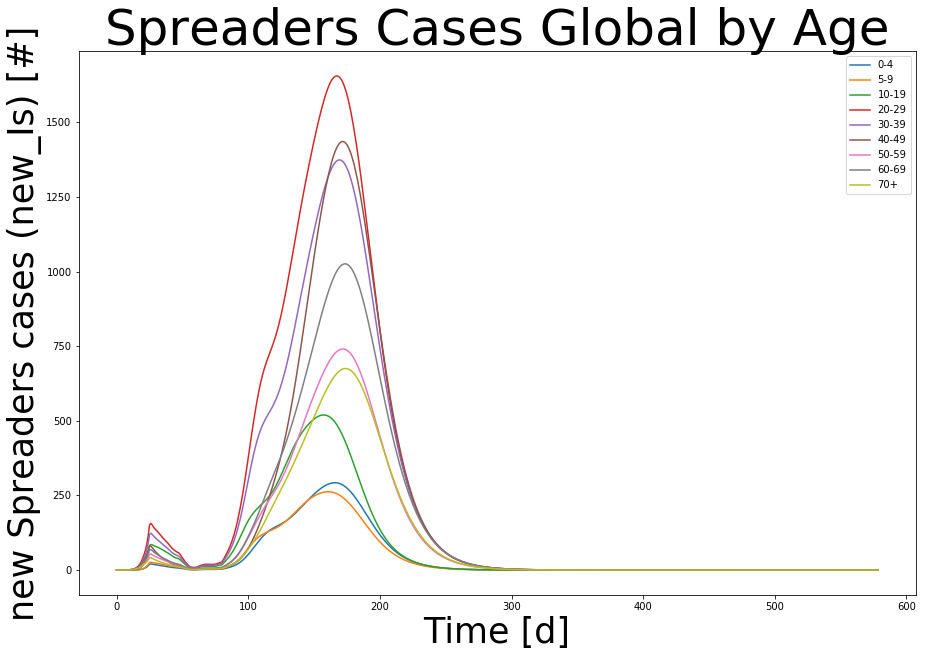

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22db56f2cc0>)

In [5]:
mdl.plot_I_by_age(ind,results[(1, '-', 0)], new_only=True)

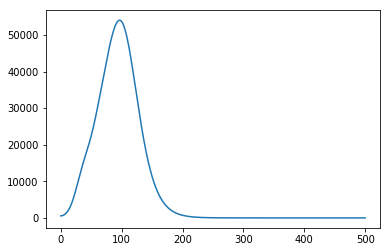

In [6]:
plt.plot(results[(1, '-', 0)]['Is'].sum(axis=1)[(start_inter-beginning).days:]*mdl.pop_israel)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.


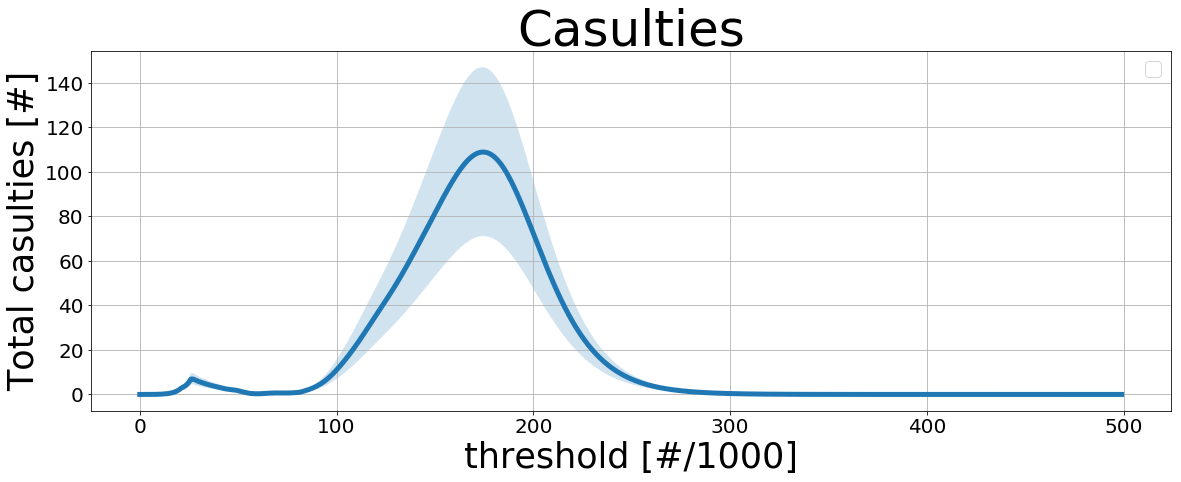

In [20]:
time_ahead = 500
mort_conf = pd.read_csv('../Data/raw/death_proba.csv')
mort_conf['pr_death_ub'] = np.maximum(mort_conf['pr_death_ub'], mort_conf['pr_death'])
mort_conf['pr_death_lb'] = np.minimum(mort_conf['pr_death_lb'], mort_conf['pr_death'])

casulties = {}
options = ['pr_death_lb', 'pr_death', 'pr_death_ub']
for vent_col in options:
    chi = mdl.expand_partial_array(ind.risk_age_dict,
                               mort_conf[vent_col].values,
                                len(ind.N))
    deaths = [np.zeros_like(res_mdl['new_Is'][0])]
    for t in range(len(res_mdl['new_Is'][:time_ahead])):
        # deaths(t)
        deaths.append((chi) * res_mdl['new_Is'][t])
    deaths = np.array(deaths)
    casulties[vent_col] = (deaths.sum(axis=1))[:time_ahead]*mdl.pop_israel

fig, ax = plt.subplots(figsize=(15, 10))
ax.set_position([0, 0.5, 1, 0.5])
ax.plot(range(len(casulties['pr_death'])), casulties['pr_death'],linewidth=5,)
ax.fill_between(range(len(casulties['pr_death'])), casulties['pr_death_lb'], casulties['pr_death_ub'], alpha=0.2)
ax.set_ylabel('Total casulties [#]', fontsize=35)
ax.set_xlabel('threshold [#/1000]', fontsize=35)
ax.set_title('Casulties', fontsize=50)
ax.grid('on')
ax.legend(fontsize = 20)
plt.setp(ax.get_xticklabels(), fontsize=20)    
plt.setp(ax.get_yticklabels(), fontsize=20) 
plt.show()

In [19]:
casulties['pr_death_lb'].sum()

5831.143617213437